# Satellite Soil Moisture Data for Extreme Event Analysis

Production date: 22-Nov-2024

Produced by: Camila Trigoso (VUB)

## 🌍 Use case: Soil moisture anomalies to detect drought periods

## ❓ Quality assessment question(s)
* **Can satellite soil moisture data be used to detect the historically reported drought of 2003 in Europe?**

The satellite soil-moisture dataset in the Climate Data Store (CDS) provides a key indicator for detecting agricultural drought. The dataset includes data from 1978 for volumetric surface soil moisture using combined active and passive sensors, and from 1991 for surface soil moisture in percentage using active sensors. The long temporal coverage enables the calculation of soil moisture anomalies (SMA) for specific periods, comparing soil moisture values of a given year with historical averages for the same period [[1]](https://drought.emergency.copernicus.eu/data/factsheets/factsheet_soilmoisture.pdf).

The objective of this study is to assess whether the CDS satellite soil-moisture dataset is suitable for detecting soil moisture anomalies during drought periods. To achieve this, we analyze the 2023 spring/summer drought in Europe as a case study and compare the results to those published in the JRC Technical Report by Toreti, A., et al., 2023 [[2]](https://publications.jrc.ec.europa.eu/repository/handle/JRC135032).

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The CDS soil-moisture dataset (volumetric surface soil moisture) successfully captures major drought events.

* Our results were mostly similar to the JDR Technical Report. However, some discrepancies were found.

* The CDS soil-moisture dataset is a valuable resource for large-scale drought analysis but may require validation with in-situ data for localized studies to address its limitations in smaller spatial scales or areas with incomplete data.
```

## 📋 Methodology

The analysis and results are organized in the following steps, which are detailed in the sections below:

**[](section-1)**
 * Download satellite-soil-moisture data from 1992 to 2023. Choose the volumetric_surface_soil_moisture variable and 10_day_average time agregation.

**[](section-2)**
 * Extract soil moisture data in Europe.
 * Calculate the dekad mean and standard deviation for the long-term period 1992 to 2022.
 * Extract 2023 data into a separate set. 
 * Calculate the SMA for 2023 in relation to the long-term period data.

**[](section-3)**
 * Plot the SMA results for the months that can be compared with literature.
 * Analyze and compare the results.
 

## 📈 Analysis and results

(section-1)=
### 1. Request and download data

#### Import packages

In [171]:
import xarray as xr
import numpy as np
import fsspec
import os
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import shapely.geometry
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from c3s_eqc_automatic_quality_control import download
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/trigoso_camila/.cdsapirc")
plt.style.use("seaborn-v0_8-notebook")

#### Set variables

In [31]:
year_start = 1979
year_stop = 2023

shapefile_url = "https://figshare.com/ndownloader/files/23392280"

#### Set the data request

In [32]:
collection_id = "satellite-soil-moisture"
request = []

for year in range(year_start, year_stop + 1):
    request.append(
        {
            "variable": "volumetric_surface_soil_moisture",
            "type_of_sensor": "combined_passive_and_active",
            "time_aggregation": "10_day_average",
            "year":  [str(year)],
            "month": [f"{month:02d}" for month in range(1, 12 + 1)],
            "day": ["01", "11", "21"],
            "type_of_record": ["cdr" if year != 2023 else "icdr"],
            "version": "v202212",
        }
    )

#### Download data

In [33]:
# Dataset
ds = download.download_and_transform(
    collection_id,
    request,
    chunks={"year": 1},
    transform_chunks=False,
)


# Shapefile
with fsspec.open(f"simplecache::{shapefile_url}") as file:
    world_shape = geopandas.read_file(file)

  0%|          | 0/45 [00:00<?, ?it/s]2024-11-20 10:20:10,062 WARNING [2024-11-19T00:00:00] Issue with underlaying infrastructure is now solved. System should gradually recover. Please check updated status [here](https://status.ecmwf.int/)
2024-11-20 10:20:10,063 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-20 10:20:10,064 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-20 10:20:10,064 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-20 10:20:10,

(section-2)=
### 2. Calculate the Soil Moisture Anomaly (SMA)

#### Select Soil Moisture data in Europe

In [109]:
#Select soil mouisture variable
da=ds["sm"]
# Filter the shapefile to keep only Europe
europe_shape = world_shape[world_shape['CONTINENT'] == 'Europe']
# Ensure soil_moisture has CRS information compatible with europe_shape (e.g., EPSG:4326)
da.rio.write_crs("EPSG:4326", inplace=True)
# Clip soil moisture data to the Europe shape
da_eu = da.rio.clip(europe_shape.geometry, europe_shape.crs, drop=True)

#### Calculate SMA for 2023

The SMA indicator was calculated as explained in the factsheet by the European Drought Observatory [[1]](https://drought.emergency.copernicus.eu/data/factsheets/factsheet_soilmoisture.pdf). The long term period chosen was 1992 to 2022 to the compared against the data for 2023. The data in both datasets are divide in dekads. The equation used was:
$$\text{SMA} = \frac{\text{SMI}_t - \overline{\text{SMI}}}{\delta_{\text{SMI}}}$$

In [157]:
# Select data for the two time intervals.
da_long_term = da_eu.sel(time=slice("1992-01-01", "2022-12-21"))

#Group by day of th year and them calculate the mean and standard deviation.
#The available days in each month are 1, 11 and 21, 
#they correspont to the 1st, 2nd and 3rd dekad of the month.
doy_long_term = da_long_term.groupby("time.dayofyear")
mean_smi_long_term = doy_long_term.mean(dim="time")
std_smi_long_term = doy_long_term.std(dim="time")

In [158]:
#Select the data of the year 2023 and calculate the mean same as before.
da_2023 = da_eu.sel(time=slice("2023-01-01", "2023-12-21"))
doy_2023 = da_2023.groupby("time.dayofyear")
smi_2023 = doy_2023.mean(dim="time")

In [160]:
# Calculate the soil moisture anomaly (SMA) for 2023
sma = (smi_2023 - mean_smi_long_term) / std_smi_long_term

(section-3)=
### 3. Plot the results and compare

#### Plot

The anomalies were plotted for the the three dekads of April, May, June and July of 2023 so the results can be compared to those obserbed by Toreti, A. et al., 2023 [[2]](https://publications.jrc.ec.europa.eu/repository/handle/JRC135032).

In [161]:
# Define custom colormap and boundaries
colors = [
    "#b35806ff",  # <-2
    "#f1a340ff",  # -2 to -1.5
    "#fee0b6ff",  # -1.5 to -1
    "#ffffffff",  # -1 to 1
    "#d1e5f0ff",  # 1 to 1.5
    "#67a9cfff",  # 1.5 to 2
    "#2166acff"   # >= 2
]
bounds = [-100, -2, -1.5, -1, 1, 1.5, 2, 100]  # Define boundaries

# Create colormap and norm
cmap = mcolors.ListedColormap(colors)
cmap.set_bad(color="#c8c8c8ff")  # Gray for no data
norm = mcolors.BoundaryNorm(bounds, ncolors=len(colors), clip=True)

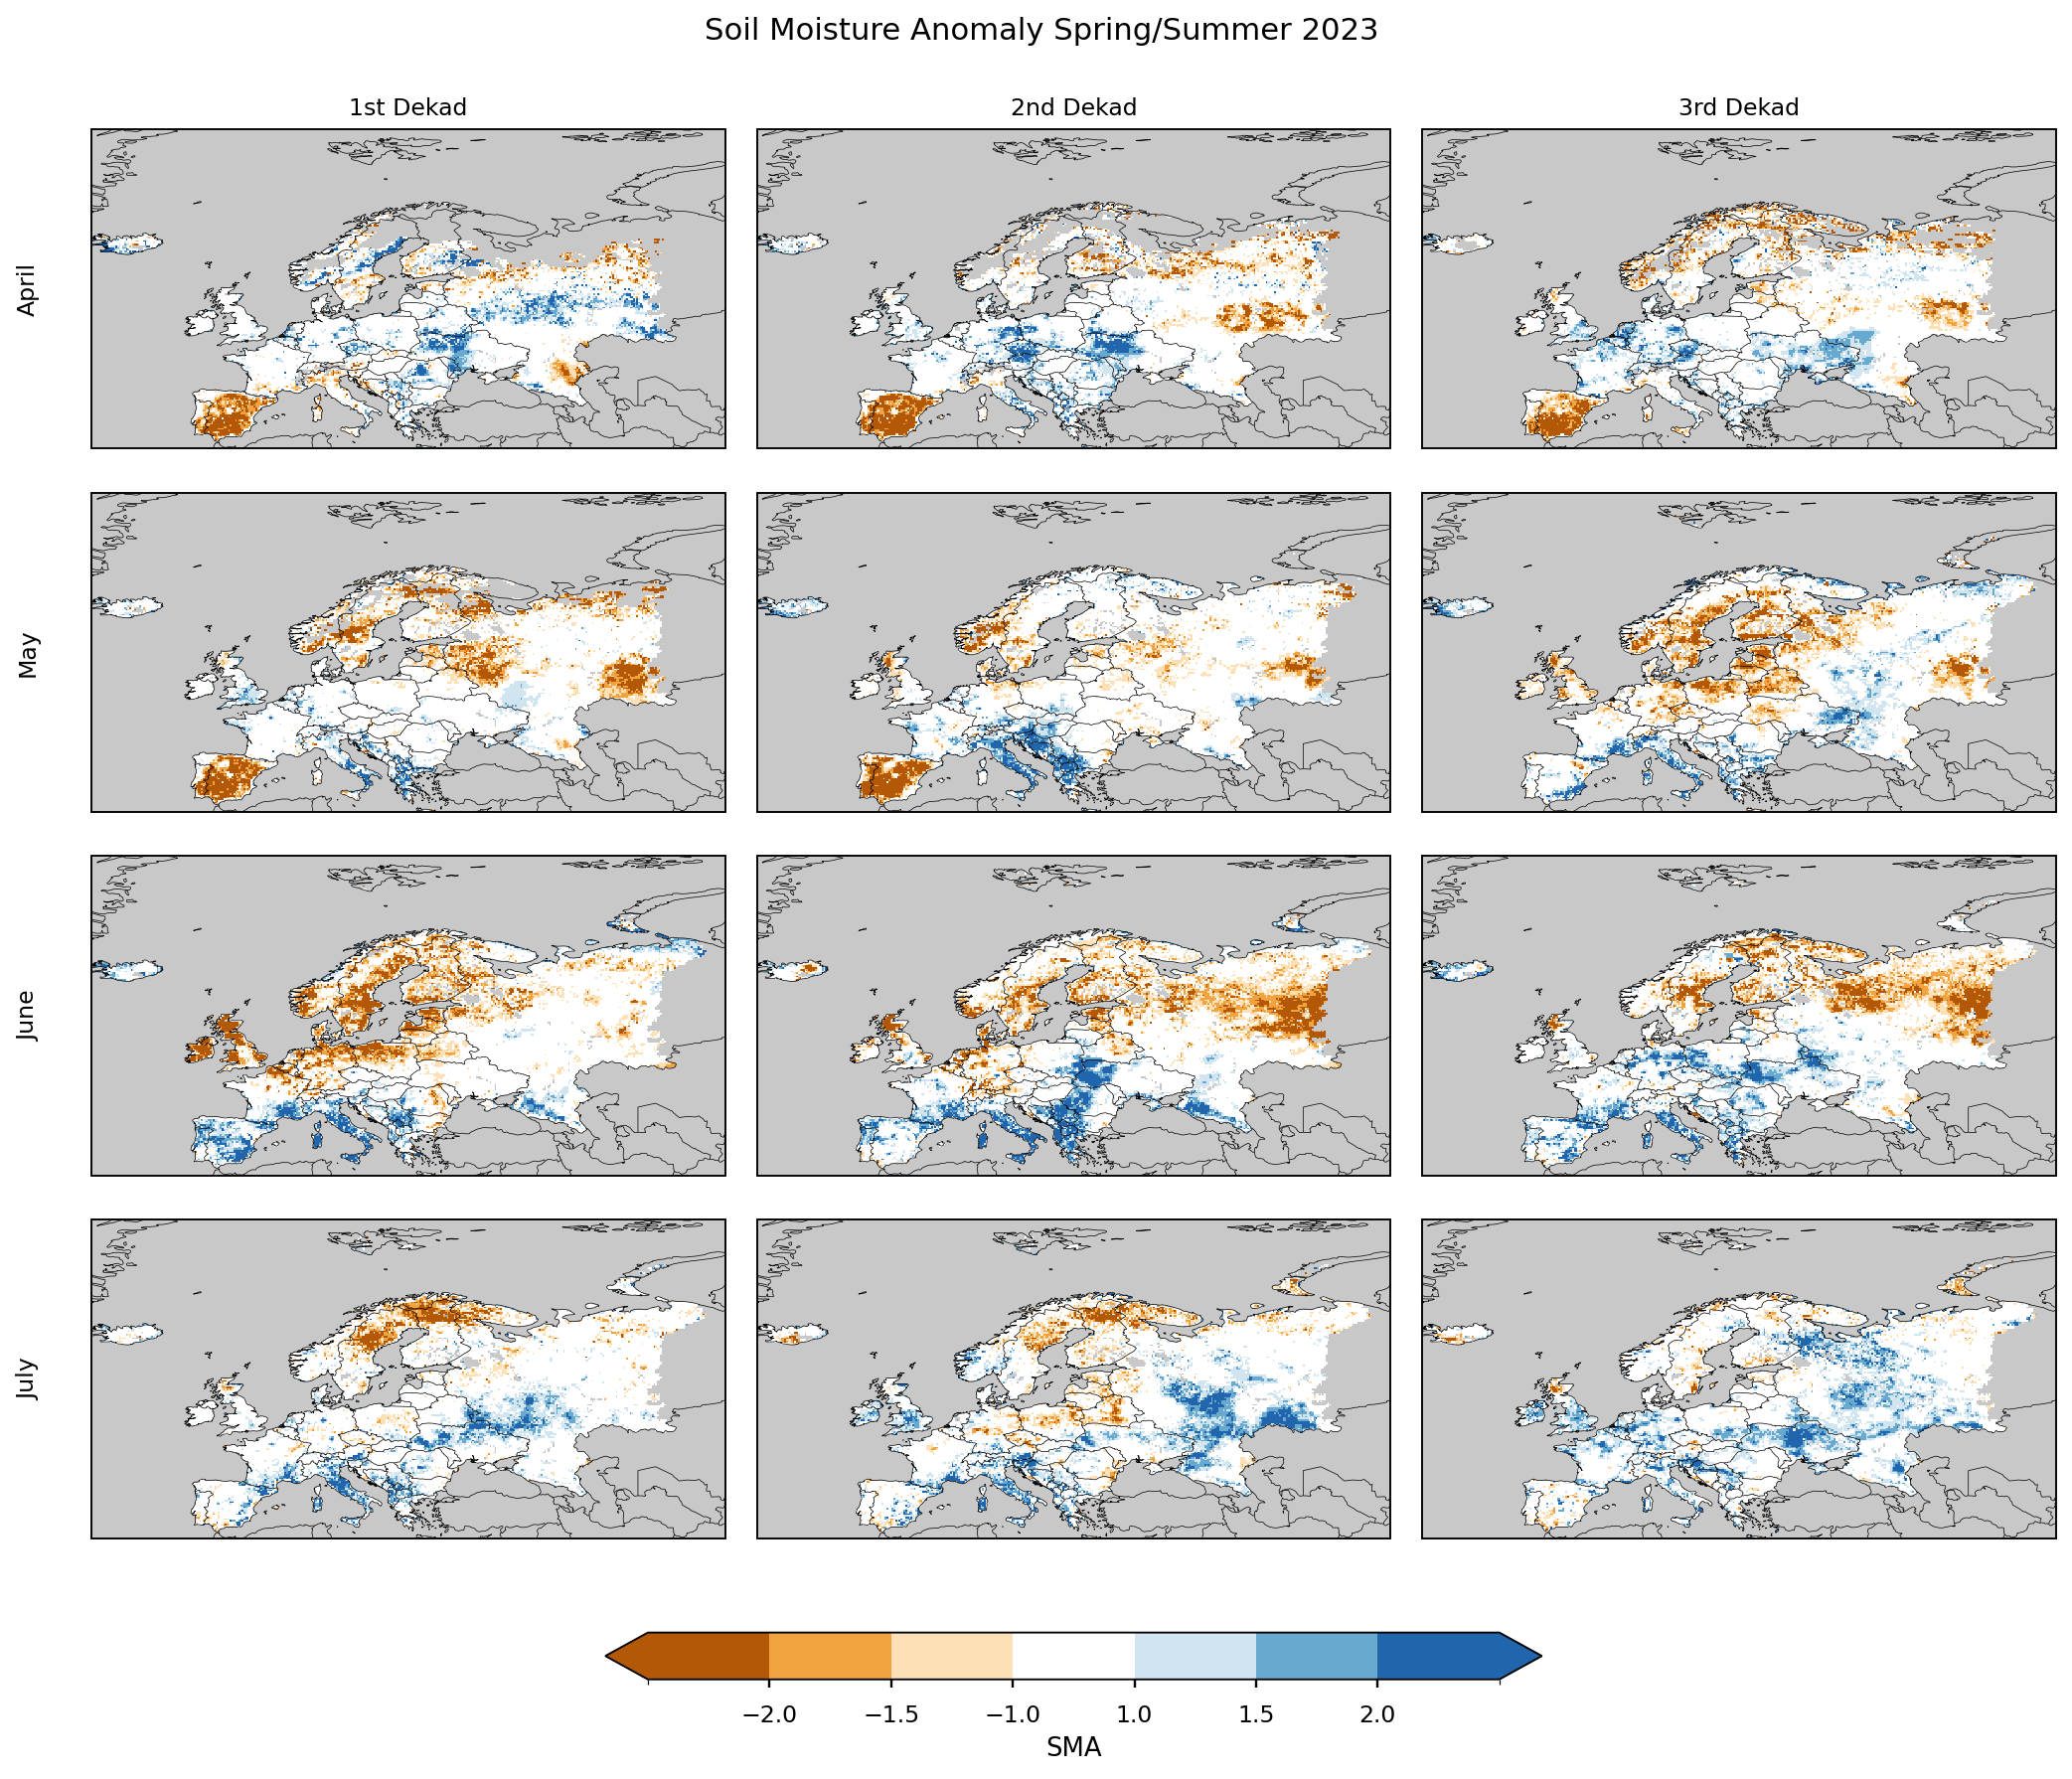

In [181]:
# Days of the year for each dekad
dekad_days = [
    [91, 101, 111],  # 1st, 2nd, and 3rd dekads for April
    [121, 131, 141],  # 1st, 2nd, and 3rd dekads for May
    [152, 162, 172],  # 1st, 2nd, and 3rd dekads for June
    [182, 192, 202],  # 1st, 2nd, and 3rd dekads for July
]

# Month labels for rows
month_labels = ['April', 'May', 'June', 'July']
dekad_labels = ['1st Dekad', '2nd Dekad', '3rd Dekad']

# Create the figure and GridSpec
fig = plt.figure(figsize=(15, 12), dpi=170)
gs = gridspec.GridSpec(4, 3, wspace=0.05, hspace=0.1)  # Adjust wspace and hspace

# Loop over rows (months) and columns (dekads)
axes = []
for row_idx, (month, days) in enumerate(zip(month_labels, dekad_days)):
    for col_idx, doy in enumerate(days):
        # Add subplot using GridSpec
        ax = fig.add_subplot(gs[row_idx, col_idx], projection=ccrs.PlateCarree())
        axes.append(ax)

        # Select specific day of the year (assuming sma is a dataset)
        sm_doy = sma.sel(dayofyear=doy)

        # Plot the data
        im = sm_doy.plot(
            cmap=cmap,
            norm=norm,
            ax=ax,
            transform=ccrs.PlateCarree(),
            add_colorbar=False,  # Don't add a colorbar here
            add_labels=False     # Suppress default titles
        )

        # Add geographic features
        ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
        ax.add_feature(cfeature.COASTLINE)

        # Set column titles for the first row
        if row_idx == 0:
            ax.set_title(dekad_labels[col_idx], fontsize=10)

        # Set row labels for the leftmost column
        if col_idx == 0:
            ax.annotate(f"{month}", xy=(-0.1, 0.5), xycoords='axes fraction',
                        ha='center', va='center', fontsize=10, rotation=90)

        # Label bottom axes
        if row_idx == 3:
            ax.set_xlabel("Longitude", fontsize=9)

# Add one shared colorbar for all subplots
cbar = fig.colorbar(
    im, ax=axes, orientation='horizontal', fraction=0.03, pad=0.06,
    ticks=bounds[1:-1], label='SMA', extend='both'
)
# Set the title for the entire figure
fig.suptitle("Soil Moisture Anomaly Spring/Summer 2023", fontsize=13, y=0.93)
# Save the figure to a file
output_filename = "/data/wp5/trigoso_camila/SoilMoisture/soil_moisture_all.png"
plt.savefig(output_filename, bbox_inches='tight')  # Save with tight layout
# Adjust layout manually if needed (GridSpec handles most of it)
plt.show()

##### Figure 1
Calculated Soil moisture anomalies for the months of April, May, June and July in year 2023 respect to the period of 1992-2022.

```{figure} attachment:247613e1-6870-4377-b404-ffbd21cdd4dc.jpg
---
height: 270px
---
```

##### Figure 2
Reference soil moisture anomalies for the months of April, May, June and July in year 2023.
Source: Toreti, A. et al., 2023 [[2]](https://publications.jrc.ec.europa.eu/repository/handle/JRC135032).
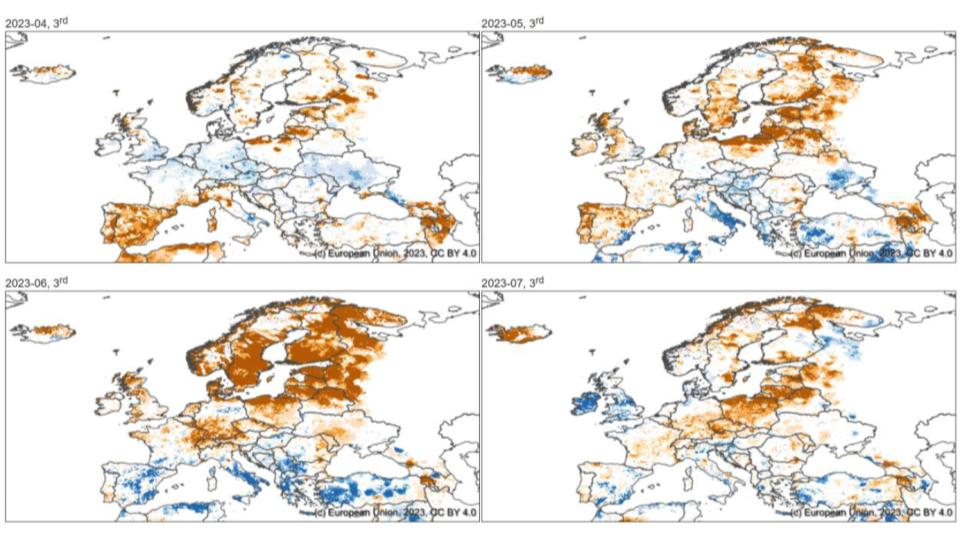

#### Analysis
The results of the SMA calculation using the CDS soil-moisture dataset (Figure 1) capture the severe drought in the Iberian Peninsula that took place from early April to mid-May of 2023. The negative anomalies in the Iberian Peninsula start receding in late May. The data from the CDS dataset is incomplete for Scandinavia in the month of April. Soil moisture was significantly lower in parts of Scandinavia in late spring and early summer of 2023, especially during the first dekad of June. Later, in the first two dekads of July, the drought was still present in the north of Scandinavia and started to recede by the end of the month. Around the Baltic Sea, negative SMA was observed mostly from late May to mid-July. From mid May to late June, dryers than usual soil moisture is observed in Ireland and the noth of the UK. However, some parts of the south of the UK were wetter than usual at certain points of April, May and July. During the first two dekads of June, a stark contrast was observed, with significantly negative SMA in central and northern Europe but also with significantly positive SMA in southern Europe. This period saw especially wetter soil moisture than normal around the Adriatic Sea.

The observations are similar to those expressed in the JDR Technical Report, Drought in Europe - August 2023 [[2]](https://publications.jrc.ec.europa.eu/repository/handle/JRC135032). In general, the trends and regions affected are similar. However, by comparing Figures 1 and 2 in detail, some discrepancies can be observed. For example, Poland and Lithuania show very negative SMA values already in April on the map from the JDR Technical Report. However, in our analysis, these countries have normal soil moisture in relation to the historical data. These differences may be due to the fact that a different reference period was chosen for the long-term SMI and differences in the data used.

In conclusion, the CDS soil-moisture dataset is a valuable tool for analyzing drought patterns at a continental scale, such as across Europe. It provides broad insights into drought trends and affected regions. However, for studies focused on smaller spatial scales or more localized drought events, it may be necessary to complement the dataset with in-situ data to ensure greater accuracy.

## ℹ️ If you want to know more

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)

Dataset documentation:
[SM v202212: Product User Guide and Specification (PUGS)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355349314)


### References


[[1]](https://drought.emergency.copernicus.eu/data/factsheets/factsheet_soilmoisture.pdf) European Commission (2019). EDO INDICATOR FACTSHEET Soil Moisture Anomaly (SMA) . European Drought Observatory.
[[2]](https://publications.jrc.ec.europa.eu/repository/handle/JRC135032) Toreti, A., Bavera, D., Acosta Navarro, J., Arias-Muñoz, C., Barbosa, P., De Jager, A., Di Ciollo, C., Fioravanti, G., Grimaldi, S., Hrast Essenfelder, A., Maetens, W., Magni, D., Masante, D., Mazzeschi, M., Mccormick, N. and Salamon, P. (2023). Drought in Europe - August 2023. Publications Office of the European Union, Luxembourg.